In [3]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.cluster import DBSCAN, HDBSCAN
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import kendalltau, norm
import cvxpy as cp
import calendar
from datetime import date
import pickle

from sb3_contrib import RecurrentPPO
import gymnasium as gym
from gymnasium import spaces
# from sklearn.linear_model import LinearRegression

import networkx as nx
from sklearn.cluster import SpectralClustering
from pandas.tseries.offsets import MonthEnd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
! pip install sb3-contrib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 17.8 MB/s eta 0:00:00


In [4]:
folder_path = '/content/drive/My Drive/fednlp/ai/'
prices_info = pd.read_csv(f'{folder_path}prices_info.csv.gz', compression='gzip')
ratios_info = pd.read_csv(f'{folder_path}ratios.csv.gz', compression='gzip')
sector_info = pd.read_csv(f'{folder_path}sector_info.csv.gz', compression='gzip')
sp500 = pd.read_pickle(f'{folder_path}sp500.pkl')
relations = pd.read_csv(f'{folder_path}lorlxamlga34g2og.csv')
rels2 = pd.read_feather(f'{folder_path}econ_link_filt2.feather')

ratios = ratios_info.drop(columns=['gvkey','cusip','adate','qdate'])

tech_features = pd.read_feather(f"{folder_path}tech_features.feather")
trading_window = pd.read_feather(f"{folder_path}trading_window.feather")
lookback_correlation_pairs = pd.read_feather(f"{folder_path}lookback_correlation_pairs.feather")
lookback_resid = pd.read_feather(f"{folder_path}lookback_resid.feather")
forward_resid = pd.read_feather(f"{folder_path}forward_resid.feather")

# with open(f"{folder_path}all_ticker_univ.pkl", "rb") as f:
#   all_ticker_univ = pickle.load(f)

with open(f"{folder_path}universe_dict3.pkl", "rb") as f:
  universe_dict3 = pickle.load(f)

rets = pd.read_feather(f"{folder_path}rets_cluster.feather")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
dynamic_portfolio_df

In [10]:
lookback_correlation_pairs

,YEAR,MONTH,TICKER_1,TICKER_2,SPEARMAN_RHO
0,2014,1,ORCL,MSFT,-0.235294
1,2014,1,ORCL,HON,-0.223529
2,2014,1,ORCL,LLTC,-0.126471
3,2014,1,ORCL,CERN,-0.014706
4,2014,1,ORCL,KO,-0.035294
...,...,...,...,...,...
1293816,2021,9,ARE,UNH,0.090909
1293817,2021,9,ARE,DG,-0.311124
1293818,2021,9,CNC,UNH,0.417278
1293819,2021,9,CNC,DG,-0.719932


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
import pandas as pd
import numpy as np

def generate_pairs_features(t1_close, t2_close, ticker1, ticker2, lookback_resid, window=30):
    """
    Helper function to calculate Z-Score, Half-Life, Hedge Ratio, and Residual Spreads.
    """
    # 1. Setup Price Data
    # Log prices are generally more stable for hedge ratios
    p1 = np.log(t1_close)
    p2 = np.log(t2_close)

    # 2. Integrate ETF Residuals
    # FIX: Handle duplicates in lookback_resid (caused by overlapping windows)

    # Process T1
    res1 = lookback_resid[lookback_resid['TICKER'] == ticker1].copy()
    res1['DATETIME'] = pd.to_datetime(res1['DATETIME'])
    # Drop duplicates on Date, keeping the most recent calculation
    res1 = res1.drop_duplicates(subset=['DATETIME'], keep='last')
    res1 = res1.set_index('DATETIME')['RESID'].rename('resid_t1')

    # Process T2
    res2 = lookback_resid[lookback_resid['TICKER'] == ticker2].copy()
    res2['DATETIME'] = pd.to_datetime(res2['DATETIME'])
    res2 = res2.drop_duplicates(subset=['DATETIME'], keep='last')
    res2 = res2.set_index('DATETIME')['RESID'].rename('resid_t2')

    # Align residuals with prices
    # We use the index from t1_close. We must ensure t1_close index is unique too (handled in main func)
    features = pd.DataFrame(index=t1_close.index)

    # Use reindex to strictly match the pricing dates (filling missing residuals with 0)
    features['resid_t1'] = res1.reindex(features.index).ffill().fillna(0)
    features['resid_t2'] = res2.reindex(features.index).ffill().fillna(0)

    # Feature: Residual Spread
    features['resid_spread'] = features['resid_t1'] - features['resid_t2']

    # 3. Rolling Hedge Ratio (Beta)
    r1 = p1.diff()
    r2 = p2.diff()

    roll_cov = r1.rolling(window=window).cov(r2)
    roll_var = r2.rolling(window=window).var()
    features['hedge_ratio'] = (roll_cov / roll_var).fillna(1.0)

    # 4. Spread & Z-Score
    features['spread'] = p1 - features['hedge_ratio'] * p2

    spread_mean = features['spread'].rolling(window=window).mean()
    spread_std = features['spread'].rolling(window=window).std()

    features['zscore'] = (features['spread'] - spread_mean) / (spread_std + 1e-8)

    # Feature: Delta
    features['delta'] = features['spread'].diff().fillna(0)

    # 5. Half-Life
    spread_lag = features['spread'].shift(1)
    rho = features['spread'].rolling(window=window).corr(spread_lag).clip(0.001, 0.999)
    features['half_life'] = -np.log(2) / np.log(rho)
    features['half_life'] = features['half_life'].fillna(window/2)

    return features


def prepare_pair_data_with_advanced_features(ticker1, ticker2, tech_features, rets, lookback_df, lookback_resid):
    """
    Master data preparation function with Robust Deduplication.
    """
    # -------------------------------------------------------
    # 1. FILTER & INDEX RAW INPUTS (With Deduplication)
    # -------------------------------------------------------
    drop_cols = ['date', 'ticker', 'close', 'open', 'high', 'low', 'volume',
                 'dlyretx', 'dlybid', 'dlyask', 'RET', 'RET_LAG_1', 'RET_LAG_2', 'RET_LAG_3', 'RET_LAG_4']

    # T1 Data
    df1 = tech_features[tech_features['ticker'] == ticker1].copy()
    df1['date'] = pd.to_datetime(df1['date'])
    # FIX: Ensure unique index for prices
    df1 = df1.drop_duplicates(subset=['date'], keep='last')
    df1 = df1.set_index('date').sort_index()
    t1_close = df1['close']

    # T2 Data
    df2 = tech_features[tech_features['ticker'] == ticker2].copy()
    df2['date'] = pd.to_datetime(df2['date'])
    # FIX: Ensure unique index for prices
    df2 = df2.drop_duplicates(subset=['date'], keep='last')
    df2 = df2.set_index('date').sort_index()
    t2_close = df2['close']

    # Raw Returns (For PnL)
    r1 = rets[rets['TICKER'] == ticker1].copy()
    r1['DATETIME'] = pd.to_datetime(r1['DATETIME'])
    # FIX: Ensure unique index for returns
    r1 = r1.drop_duplicates(subset=['DATETIME'], keep='last')
    r1 = r1.set_index('DATETIME')['RET'].sort_index().rename('raw_ret')

    r2 = rets[rets['TICKER'] == ticker2].copy()
    r2['DATETIME'] = pd.to_datetime(r2['DATETIME'])
    # FIX: Ensure unique index for returns
    r2 = r2.drop_duplicates(subset=['DATETIME'], keep='last')
    r2 = r2.set_index('DATETIME')['RET'].sort_index().rename('raw_ret')

    # -------------------------------------------------------
    # 2. GENERATE ADVANCED PAIRS FEATURES
    # -------------------------------------------------------
    # Now that indices are guaranteed unique, this will run without error
    pairs_feats = generate_pairs_features(t1_close, t2_close, ticker1, ticker2, lookback_resid)

    # -------------------------------------------------------
    # 3. ALIGN EVERYTHING
    # -------------------------------------------------------
    df1_clean = df1.drop(columns=[c for c in drop_cols if c in df1.columns], errors='ignore').select_dtypes(include=[np.number]).add_prefix('t1_')
    df2_clean = df2.drop(columns=[c for c in drop_cols if c in df2.columns], errors='ignore').select_dtypes(include=[np.number]).add_prefix('t2_')

    aligned = pd.concat([
        df1_clean,
        df2_clean,
        pairs_feats,
        r1.rename('ret1'),
        r2.rename('ret2')
    ], axis=1, join='inner')

    # -------------------------------------------------------
    # 4. ADD CORRELATIONS
    # -------------------------------------------------------
    # A. Rolling Pearson
    aligned['rolling_pearson'] = aligned['ret1'].rolling(window=30).corr(aligned['ret2']).fillna(0)

    # B. Monthly Spearman
    mask_pair = (
        ((lookback_df['TICKER_1'] == ticker1) & (lookback_df['TICKER_2'] == ticker2)) |
        ((lookback_df['TICKER_1'] == ticker2) & (lookback_df['TICKER_2'] == ticker1))
    )
    pair_spearman = lookback_df[mask_pair].copy()

    # Deduplicate Spearman data just in case
    pair_spearman = pair_spearman.drop_duplicates(subset=['YEAR', 'MONTH'])

    daily_dates = pd.DataFrame(index=aligned.index)
    daily_dates['YEAR'] = daily_dates.index.year
    daily_dates['MONTH'] = daily_dates.index.month

    merged_spearman = pd.merge(
        daily_dates.reset_index(),
        pair_spearman[['YEAR', 'MONTH', 'SPEARMAN_RHO']],
        on=['YEAR', 'MONTH'],
        how='left'
    ).drop_duplicates(subset=['index']).set_index('index')

    aligned['monthly_spearman'] = merged_spearman['SPEARMAN_RHO'].reindex(aligned.index).fillna(0)

    # -------------------------------------------------------
    # 5. FINAL CLEANUP
    # -------------------------------------------------------
    aligned = aligned.dropna()

    final_obs = aligned.drop(columns=['ret1', 'ret2'])
    final_ret1 = aligned['ret1']
    final_ret2 = aligned['ret2']

    return final_obs, final_ret1, final_ret2

In [6]:
def select_monthly_dynamic_portfolio(lookback_corr, rets, top_n_per_sector=2):
    """
    Selects top N pairs per cluster (gsector) for each month based on Correlation strength.
    """
    print("Selecting monthly portfolios...")

    # 1. Map Tickers to Sectors (gsector)
    # We create a lookup table from the 'rets' dataframe
    # We drop duplicates to get a unique Ticker -> Sector mapping
    # (Assuming tickers don't change sectors frequently, we take the most recent)
    ticker_sector_map = rets[['TICKER', 'gsector']].drop_duplicates(subset=['TICKER'], keep='last').set_index('TICKER')['gsector'].to_dict()

    # 2. Helper to identify pair sector
    def get_pair_sector(row):
        s1 = ticker_sector_map.get(row['TICKER_1'])
        s2 = ticker_sector_map.get(row['TICKER_2'])
        # We only trade pairs within the same sector (Cluster)
        if s1 == s2 and s1 is not None:
            return s1
        return -1 # Invalid or Cross-sector

    # 3. Enhance Correlation Table
    df = lookback_corr.copy()
    df['gsector'] = df.apply(get_pair_sector, axis=1)

    # Filter valid within-cluster pairs
    df = df[df['gsector'] != -1]

    # Create Absolute Correlation for ranking (High neg correlation is also good)
    df['abs_rho'] = df['SPEARMAN_RHO'].abs()

    # 4. Group by Year/Month/Sector and pick Top N
    # Sort by Year, Month, Sector, and Strength
    df = df.sort_values(['YEAR', 'MONTH', 'gsector', 'abs_rho'], ascending=[True, True, True, False])

    # Select top N
    selected_portfolio = df.groupby(['YEAR', 'MONTH', 'gsector']).head(top_n_per_sector)

    print(f"Total Portfolio Universes generated: {len(selected_portfolio.groupby(['YEAR', 'MONTH']))} months")
    print(f"Total Unique Pairs to Train: {len(selected_portfolio[['TICKER_1', 'TICKER_2']].drop_duplicates())}")

    return selected_portfolio


import pandas as pd

def get_target_universe(lookback_corr, rets, top_n_per_sector=5):
    """
    Selects the top N correlated pairs from each sector, ensuring NO self-pairs.
    """
    print("Generating Target Universe...")

    # 1. Map Tickers to Sectors
    ticker_map = rets[['TICKER', 'gsector']].drop_duplicates(subset=['TICKER'], keep='last').set_index('TICKER')['gsector'].to_dict()

    def get_sector(row):
        t1, t2 = row['TICKER_1'], row['TICKER_2']

        # CRITICAL FIX: Reject if Ticker 1 == Ticker 2
        if t1 == t2:
            return -1

        s1 = ticker_map.get(t1)
        s2 = ticker_map.get(t2)

        # Only keep pairs in the same cluster
        return s1 if s1 == s2 and s1 is not None else -1

    # 2. Filter and Rank
    df = lookback_corr.copy()
    df['gsector'] = df.apply(get_sector, axis=1)

    # Remove cross-sector pairs AND self-pairs (marked as -1 above)
    df = df[df['gsector'] != -1]

    # Sort by strength of correlation
    df['abs_rho'] = df['SPEARMAN_RHO'].abs()

    # Remove Duplicate Combinations (e.g. A-B and B-A)
    # We normalize by sorting tickers alphabetically per row
    # This creates a 'signature' so A-B and B-A become the same string
    df['pair_key'] = df.apply(lambda r: "-".join(sorted([r['TICKER_1'], r['TICKER_2']])), axis=1)
    df = df.drop_duplicates(subset=['pair_key'])

    # Pick Top N per Sector
    target_universe = df.sort_values('abs_rho', ascending=False).groupby('gsector').head(top_n_per_sector)

    print(f"Selected {len(target_universe)} unique pairs across {target_universe['gsector'].nunique()} sectors.")
    return target_universe[['TICKER_1', 'TICKER_2', 'gsector', 'SPEARMAN_RHO']]

In [7]:
def analyze_results(results, ticker1, ticker2):
    """
    Calculates Sharpe, Max Drawdown, and plots performance.
    """
    # 1. Calculate Metrics
    results['Daily_Return'] = results['Portfolio_Value'].pct_change().fillna(0)

    # Cumulative Return
    total_ret = (results['Portfolio_Value'].iloc[-1] / results['Portfolio_Value'].iloc[0]) - 1

    # Sharpe Ratio (Assuming 252 trading days, risk-free=0)
    avg_ret = results['Daily_Return'].mean()
    std_ret = results['Daily_Return'].std()
    sharpe = (avg_ret / std_ret) * np.sqrt(252) if std_ret > 0 else 0

    # Max Drawdown
    cum_ret = (1 + results['Daily_Return']).cumprod()
    peak = cum_ret.cummax()
    drawdown = (cum_ret - peak) / peak
    max_drawdown = drawdown.min()

    print(f"--- Backtest Results: {ticker1} vs {ticker2} ---")
    print(f"Total Return:   {total_ret*100:.2f}%")
    print(f"Sharpe Ratio:   {sharpe:.2f}")
    print(f"Max Drawdown:   {max_drawdown*100:.2f}%")
    print(f"Final Balance:  ${results['Portfolio_Value'].iloc[-1]:,.2f}")

    # 2. Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    # Equity Curve
    ax1.plot(results.index, results['Portfolio_Value'], label='RL Strategy', color='green')
    ax1.set_title(f'Equity Curve: {ticker1}-{ticker2}')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Positions (Hedge Ratio / Weights)
    ax2.plot(results.index, results['Position'], label='Net Position', color='blue', linewidth=1)
    ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax2.set_title('Agent Positioning (-1 Short Spread, +1 Long Spread)')
    ax2.set_ylabel('Position')
    ax2.grid(True, alpha=0.3)

    # Drawdown
    ax3.fill_between(results.index, drawdown, 0, color='red', alpha=0.3)
    ax3.set_title('Drawdown')
    ax3.set_ylabel('% Drawdown')
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results

In [15]:
import os

file_path = '/content/drive/My Drive/fednlp/ai/models_v1'

if os.path.exists(file_path):
    print("Path exists!")

Path exists!


Selecting monthly portfolios...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Total Portfolio Universes generated: 48 months
Total Unique Pairs to Train: 155
Generating Trading Schedule...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Backtesting 106 unique pairs...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


  0%|          | 0/106 [00:00<?, ?it/s]

Model missing for NLSN-KSS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.18883494 -0.26267299 -0.25686583 ... -0.93875855 -0.87482834
 -0.83686638]
[-0.00299171 -0.00235959 -0.00633226 ...  0.00451261  0.00567764
 -0.        ]
Model missing for MET-PRU


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.03794179 -0.04456452 -0.06492241 ... -0.76650238 -0.78421915
 -0.76725709]
[-0.00026977  0.00040228 -0.00136759 ...  0.00103784 -0.00103752
 -0.        ]
Model missing for GS-AMP


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.05308241 -0.1505197  -0.1807652  ... -0.57567847 -0.59864062
 -0.60916138]
[-0.0005812   0.00084321  0.00323895 ... -0.00318293  0.00310275
 -0.        ]
Model missing for MCO-NTRS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.26581746 -0.30760744 -0.30199164 ... -1.         -1.
 -0.996692  ]
[ 0.0020436  -0.00068504 -0.00639769 ... -0.003723   -0.001998
 -0.        ]
Model missing for STJ-BSX


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-2.93500245e-01 -3.66281301e-01 -3.80456835e-01 -4.25645709e-01
 -5.37879944e-01 -5.82465172e-01 -5.98217010e-01 -6.19956136e-01
 -5.92701972e-01 -5.89897752e-01 -5.66176295e-01 -6.40299320e-01
 -6.04537606e-01 -5.92376173e-01 -5.90743244e-01 -5.88470459e-01
 -5.94947457e-01 -6.94555879e-01 -6.86696172e-01 -7.40823627e-01
 -7.82383978e-01 -7.85511732e-01 -7.39704072e-01 -6.71833038e-01
 -6.37227237e-01 -6.68567181e-01 -6.36643052e-01 -5.67662597e-01
 -5.30143857e-01 -5.11060178e-01 -5.87216616e-01 -7.24322677e-01
 -7.76327729e-01 -8.46793771e-01 -9.04942274e-01 -9.41941023e-01
 -9.34382439e-01 -8.83696198e-01 -8.30157042e-01 -8.09127688e-01
 -7.88597345e-01 -7.60467410e-01 -7.00254679e-01 -6.83374286e-01
 -6.30952001e-01 -5.85756063e-01 -5.22556782e-01 -4.86538857e-01
 -5.03023803e-01 -5.89841068e-01 -5.30377805e-01 -4.86325949e-01
 -4.54909563e-01 -4.92611021e-01 -5.33008754e-01 -6.08538389e-01
 -6.34221435e-01 -6.51706457e-01 -6.71344638e-01 -6.76503897e-01
 -6.45590425e-01 -6.10724

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.22383164 -0.34026265 -0.36242384 ... -0.29951584 -0.21195769
 -0.11440849]
[ 0.00309828  0.0033999   0.00040084 ... -0.00150866  0.00069268
 -0.        ]
Model missing for EQR-AVB


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.27310988 -0.27983204 -0.22901271 ... -0.61427474 -0.65226734
 -0.67865956]
[-0.00195192  0.00098921 -0.00063666 ... -0.00025554 -0.00496571
 -0.        ]
Model missing for CB-TRV


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.28270268 -0.35224092 -0.39720315 ... -0.94871461 -0.98928177
 -0.97635859]
[ 0.00173042  0.00080522 -0.00120353 ...  0.00170389  0.00100907
 -0.        ]
Model missing for MET-PFG


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.0509084   0.07579269  0.1080417  ... -0.98417246 -0.95951355
 -0.91810465]
[-0.00054574 -0.00039965  0.00104865 ...  0.00277537 -0.00211861
 -0.        ]
Model missing for BEN-STT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.36294001 -0.39150015 -0.43094045 ...  0.2027569   0.24362998
  0.31679571]
[ 0.00162597  0.00046236 -0.00429734 ... -0.0047808   0.00250305
  0.        ]
Model missing for NTRS-BLK


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[ 0.0685369  -0.02445149  0.00632087 ... -0.51584971 -0.4732883
 -0.44688058]
[-1.95193091e-04 -1.99817580e-04 -3.26852116e-05 ... -2.85935494e-03
  3.69164872e-05 -0.00000000e+00]
Model missing for BDX-HSP


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.29993314 -0.48565313 -0.50666875 -0.5544275  -0.58532202 -0.62025136
 -0.6038745  -0.60713035 -0.56798959 -0.51900113 -0.46662182 -0.54325235
 -0.57494944 -0.6354838  -0.64193773 -0.67988837 -0.67593622 -0.73976445
 -0.7198174  -0.77601272 -0.80742168 -0.8113997  -0.76375556 -0.70152557
 -0.65639848 -0.6633606  -0.64655888 -0.60139334 -0.59747458 -0.5484761
 -0.5789957  -0.70540905 -0.8097477  -0.93861395 -0.91397536 -0.89105046
 -0.83245265 -0.76478231 -0.64936209 -0.61757106 -0.54816616 -0.47456533
 -0.46033424 -0.42923549 -0.3808628  -0.32692081 -0.32622671 -0.31341064
 -0.35259509 -0.40180087 -0.4730131  -0.51591301 -0.54204094 -0.55616713
 -0.6037733  -0.63691294 -0.67136353 -0.70304066 -0.73056728 -0.72568119
 -0.74259758 -0.86288667 -0.8836931  -0.89939791 -0.90776253 -0.91918755
 -0.90925074 -0.83667403 -0.80981326 -0.81569827 -0.8648293  -0.82778573
 -0.78845942 -0.7204051  -0.67075765 -0.60735595 -0.49598053 -0.42004275
 -0.44582492 -0.45149696 -0.51933295 -0.58189619 -0.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[ 5.85539304e-02 -9.01560262e-02 -7.92423710e-02 -7.93623254e-02
 -1.03901386e-01 -8.60960409e-02 -1.28120705e-01 -2.13101089e-01
 -3.33792686e-01 -4.62938607e-01 -5.20490766e-01 -6.07172251e-01
 -6.63695574e-01 -6.59743667e-01 -6.60848618e-01 -6.25336409e-01
 -5.75153291e-01 -5.67365885e-01 -5.61822891e-01 -5.66242933e-01
 -5.42815626e-01 -6.08203232e-01 -5.39573252e-01 -4.71519679e-01
 -4.29684937e-01 -4.99355882e-01 -4.70648587e-01 -4.44347978e-01
 -4.28249359e-01 -4.82173294e-01 -4.99598593e-01 -6.24047041e-01
 -6.80278063e-01 -6.79448009e-01 -6.43507242e-01 -5.69314837e-01
 -4.51222837e-01 -3.35965276e-01 -2.33887270e-01 -1.56170934e-01
 -9.34815630e-02 -1.16948664e-01 -1.18162736e-01 -2.24683762e-01
 -3.30634356e-01 -4.02510792e-01 -3.71558696e-01 -2.53242046e-01
 -1.99529171e-01 -1.09942406e-01 -1.37717143e-01 -1.85630709e-01
 -2.10126176e-01 -2.42757782e-01 -1.90490112e-01 -2.30270252e-01
 -2.92952478e-01 -3.22189152e-01 -3.76625896e-01 -3.70645046e-01
 -4.10672456e-01 -4.21624

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.09002906 -0.05889413 -0.0125689  ...  1.          1.
  1.        ]
[-2.41637999e-04  2.06600613e-04  5.05269645e-06 ...  2.21080000e-02
 -1.78260000e-02  0.00000000e+00]
Model missing for IVZ-BEN


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.00080899  0.14948478  0.24744086 ... -0.55425704 -0.60371768
 -0.62195057]
[-1.37124531e-06  8.79867435e-04  5.63620790e-03 ... -8.48567521e-03
  5.40387700e-03 -0.00000000e+00]
Model missing for LM-ACE


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-1.00202180e-01  2.14598522e-01  2.36974433e-01  1.80179611e-01
  1.35562703e-01  8.44321847e-02  3.34547646e-02 -4.03463207e-02
 -1.30881056e-01 -1.83691725e-01 -2.40725458e-01 -4.10850346e-01
 -4.30499375e-01 -4.47590292e-01 -5.41491508e-01 -4.95646536e-01
 -5.39799511e-01 -5.34092546e-01 -5.96070647e-01 -6.59958482e-01
 -6.58891559e-01 -6.52029872e-01 -6.40232325e-01 -5.70500612e-01
 -5.40613294e-01 -5.72092235e-01 -5.99016368e-01 -6.04517221e-01
 -5.85678816e-01 -5.31325281e-01 -5.41439235e-01 -6.22343302e-01
 -6.60298228e-01 -7.21580625e-01 -6.71070576e-01 -6.51890874e-01
 -5.00447512e-01 -3.66717309e-01 -2.22827300e-01 -1.53469756e-01
 -7.01514557e-02 -7.29873478e-02 -7.29389861e-02 -4.77631502e-02
  4.54673581e-02  5.18302582e-02  1.82161450e-01  2.56477028e-01
  3.38493347e-01  3.78384471e-01  4.16843891e-01  4.00199413e-01
  4.23001349e-01  3.03305924e-01  1.30319223e-01 -4.69334088e-02
 -1.02208368e-01 -1.69554040e-01 -2.47002572e-01 -2.90928334e-01
 -3.71811688e-01 -4.95072

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.06204184 -0.17175406 -0.16796666 ... -0.38755953 -0.52072364
 -0.59899604]
[ 9.32674946e-04  1.33968168e-05 -1.10690031e-04 ...  1.03044329e-02
 -4.95156110e-03 -0.00000000e+00]
Model missing for HIG-AIZ


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.18606707  0.0651347   0.05162165 ... -0.54480034 -0.52331328
 -0.48947257]
[-3.34009006e-03 -2.82033237e-05  4.84882153e-04 ... -2.88635221e-03
  1.71908414e-03 -0.00000000e+00]
Model missing for NTRS-STT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.1866526  -0.29866201 -0.31178796 ... -0.4080776  -0.38327616
 -0.34499216]
[ 0.00213232 -0.00255535  0.00119851 ...  0.00304222  0.00038826
 -0.        ]
Model missing for STT-AMP


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.05906705 -0.09766421 -0.08477024 ... -0.3787176  -0.29670382
 -0.20079593]
[-1.14584167e-03 -2.25604336e-05  1.68362173e-03 ... -2.67033781e-03
  1.44939814e-03 -0.00000000e+00]
Model missing for BDX-SYK


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.26562363 -0.3140623  -0.33180523 ... -0.44727069 -0.48714063
 -0.50181806]
[-5.97653165e-05  2.09950646e-03 -3.71621857e-04 ... -2.03284529e-03
 -3.74611141e-03 -0.00000000e+00]
Model missing for FDO-BBBY


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.16668825 -0.42862782 -0.47648621 -0.5427323  -0.6381321  -0.72454518
 -0.79722345 -0.80664551 -0.79521674 -0.79970968 -0.77580905 -0.74669009
 -0.69786137 -0.71970236 -0.74109828 -0.78093404 -0.7494545  -0.75197434
 -0.74724591 -0.80806255 -0.79482681 -0.78077519 -0.63691467 -0.5365324
 -0.48424917 -0.49453732 -0.4178164  -0.31939724 -0.24050306 -0.18345577
 -0.23577397 -0.42167938 -0.47671509 -0.59506941 -0.60442245 -0.56074929
 -0.51439142 -0.34599084 -0.2094207  -0.04339996  0.11605405  0.22125295
  0.31995872  0.31178409  0.26699632  0.25889176  0.24651663  0.21744333
  0.14496858  0.03764743 -0.0182106  -0.08358962 -0.11083997 -0.16053885
 -0.22317055 -0.31826746 -0.44542751 -0.51898742 -0.58001971 -0.63017964
 -0.6728785  -0.74779832 -0.73489118 -0.82024521 -0.81317914 -0.793594
 -0.77642691 -0.75435734 -0.74584126 -0.77970362 -0.76316977 -0.76050901
 -0.78334123 -0.73576534 -0.74039185 -0.7480157  -0.74523699 -0.7335676
 -0.75780523 -0.78691483 -0.79469037 -0.78358603 -0.883

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.06141511 -0.17447472 -0.25802144 ... -0.90384066 -0.92674667
 -0.92794132]
[-0.00031659  0.00209125  0.00242179 ... -0.00332342 -0.00124925
 -0.        ]
Model missing for STT-GS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.15040462 -0.18482924 -0.18427943 ... -0.59564888 -0.58813548
 -0.54137218]
[-0.00127092 -0.00107811  0.00035805 ... -0.00090658 -0.00017526
 -0.        ]
Model missing for STJ-SYK


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-1.01203613e-01 -4.36412655e-02  4.27248664e-02  5.50967641e-02
 -2.99528725e-02 -9.11205411e-02 -1.19943686e-01 -2.08662078e-01
 -2.51857162e-01 -2.75497168e-01 -1.91789001e-01 -3.67443413e-01
 -4.37899172e-01 -5.32080710e-01 -6.79081321e-01 -7.12940037e-01
 -7.22352982e-01 -8.03419471e-01 -7.86188364e-01 -7.78912067e-01
 -8.07327092e-01 -7.65532851e-01 -6.80528641e-01 -6.11999929e-01
 -5.96359730e-01 -6.83599353e-01 -6.97981834e-01 -6.23190105e-01
 -5.45323551e-01 -4.67281282e-01 -5.05653560e-01 -6.09297037e-01
 -6.74720764e-01 -7.77871370e-01 -7.94026077e-01 -8.43865097e-01
 -8.66487622e-01 -8.71013045e-01 -8.84923100e-01 -9.08905625e-01
 -9.41976786e-01 -9.02652144e-01 -8.09116304e-01 -7.04291582e-01
 -6.04111850e-01 -5.55642605e-01 -5.07751286e-01 -5.11122465e-01
 -5.29023170e-01 -5.66660583e-01 -4.86570209e-01 -4.66394037e-01
 -4.27682072e-01 -4.03051496e-01 -4.19300973e-01 -4.15278554e-01
 -4.26394522e-01 -4.99872714e-01 -5.59831500e-01 -6.08200133e-01
 -5.88317275e-01 -5.91447

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.35863876 -0.39644903 -0.36592826 ... -0.83210045 -0.90655893
 -0.94746208]
[ 5.40468616e-04 -9.23726239e-05  1.92844194e-04 ...  4.60151549e-04
  7.72025586e-03 -0.00000000e+00]
Model missing for M-KSS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.27002501 -0.39678305 -0.43392098 ... -0.34163553 -0.33026475
 -0.33991593]
[-0.00455235  0.01183167 -0.00107612 ... -0.01970451 -0.00137753
 -0.        ]
Model missing for KSS-KMX


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.12889731 -0.2622757  -0.29273206 ...  0.17298146  0.09646831
 -0.0466983 ]
[ 0.00252832 -0.00664082 -0.00499752 ...  0.00318822 -0.00100433
 -0.        ]
Model missing for IVZ-SCHW


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.29964951 -0.3931495  -0.41665161 ... -0.48294741 -0.4822253
 -0.44409895]
[-0.0046146   0.00329813 -0.00060539 ...  0.00022892  0.00052177
 -0.        ]
Model missing for CNX-QEP


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.36119124 -0.49921605 -0.5548898  -0.64215702 -0.7349183  -0.79362816
 -0.83845407 -0.88669205 -0.89839059 -0.89894563 -0.85452712 -0.85999107
 -0.84918499 -0.804223   -0.78000975 -0.78481066 -0.80672032 -0.85274267
 -0.90405822 -0.91943049 -0.8471601  -0.79442036 -0.73025298 -0.68707436
 -0.72630614 -0.74957454 -0.69343543 -0.67838264 -0.59446067 -0.50179881
 -0.48795426 -0.58600855 -0.5772537  -0.60499638 -0.61890519 -0.64357841
 -0.62718296 -0.58732986 -0.50400853 -0.44168574 -0.33977887 -0.19500025
 -0.14056714 -0.01977031  0.05512984  0.13340767  0.19683975  0.18619929
  0.13994038  0.09021588  0.04991786  0.09073463  0.13591088  0.18813209
  0.19399683  0.18485133  0.19432722  0.21200199  0.1937993   0.14744498
  0.06191466 -0.02321218 -0.08700158 -0.22128938 -0.32984143 -0.44780451
 -0.59776247 -0.65569162 -0.6831131  -0.65746611 -0.64665794 -0.61549473
 -0.58732867 -0.65123188 -0.62454814 -0.62336755 -0.59926927 -0.59162688
 -0.6293937  -0.65799046 -0.74420619 -0.76254904 -0

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.43457991 -0.55550116 -0.61477172 ... -0.55319345 -0.5251416
 -0.55018616]
[-0.00576601 -0.00310081  0.02869939 ...  0.00669807 -0.01120705
 -0.        ]
Model missing for EQR-ESS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.1332069  -0.08050643 -0.0577158  ... -0.69934702 -0.75528318
 -0.76769972]
[-5.01390786e-04 -1.07073551e-04 -3.93621754e-04 ...  9.58105416e-05
  6.82020709e-04 -0.00000000e+00]
Model missing for HIG-PFG


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.07845759  0.15011711  0.12107127 ... -0.94025654 -0.91064197
 -0.86550415]
[-0.00103509  0.0004478   0.00025546 ...  0.00136525  0.00103904
 -0.        ]
Model missing for CME-ICE


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.01068641 -0.19993199 -0.20632184 ... -1.         -1.
 -1.        ]
[-5.15085080e-06 -7.21554567e-04 -4.90385739e-03 ...  2.11700000e-03
 -5.43300000e-03 -0.00000000e+00]
Model missing for MS-STT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.15707676 -0.10104978 -0.0318692  ... -0.3951759  -0.35068446
 -0.29219618]
[-0.00038405  0.00054264 -0.00066329 ...  0.00194624 -0.00038014
 -0.        ]
Model missing for RDC-PXD


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[ 0.03433424 -0.02628652 -0.04644438 -0.10134364 -0.18069027 -0.25120294
 -0.31863546 -0.32023987 -0.33204627 -0.32395178 -0.32673985 -0.39009678
 -0.3697114  -0.37147418 -0.3652918  -0.35529265 -0.39411059 -0.46899995
 -0.47557151 -0.48752463 -0.50030267 -0.49842256 -0.43350232 -0.35784307
 -0.33548516 -0.33335689 -0.30255228 -0.18937479 -0.14904632 -0.02535929
  0.03337057 -0.17142816 -0.3299011  -0.50647455 -0.47250038 -0.43288022
 -0.38832891 -0.38276717 -0.38087511 -0.30669621 -0.26486936 -0.16866915
 -0.21334834 -0.19705325 -0.235889   -0.30632463 -0.3342956  -0.42405319
 -0.49619985 -0.51937079 -0.46754953 -0.37198782 -0.38925037 -0.44515318
 -0.58545005 -0.68397093 -0.80805957 -0.84064031 -0.87718832 -0.87060618
 -0.81813681 -0.72546721 -0.68090278 -0.74537289 -0.75375807 -0.74606669
 -0.71577466 -0.69198489 -0.685691   -0.72764271 -0.75415576 -0.82524574
 -0.83925015 -0.80669785 -0.76661372 -0.70887953 -0.60002398 -0.50081772
 -0.43706512 -0.3697651  -0.3712697  -0.38147584 -0

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.06614029 -0.18935485 -0.27197108 ... -0.51093858 -0.59744656
 -0.63783526]
[ 0.00023877  0.00071084 -0.00308932 ... -0.00074904  0.00052874
 -0.        ]
Model missing for STT-CME


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.28911859 -0.30304086 -0.29456916 ... -0.8635664  -0.92326254
 -0.9457072 ]
[-0.00321124  0.00200068  0.00799431 ... -0.00465808  0.0040125
 -0.        ]
Model missing for STT-SCHW


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.33324176 -0.48255029 -0.53215647 ... -0.96577311 -0.93847716
 -0.97778559]
[-0.00606     0.00631851  0.0166549  ... -0.0075282   0.00225704
 -0.        ]
Model missing for NFX-NOV


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.12319584 -0.08480199 -0.01082017 ... -0.42900211 -0.4693141
 -0.5203768 ]
[ 0.00183352  0.00053273 -0.00053043 ... -0.00761822  0.0008917
 -0.        ]
Model missing for MMC-AON


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.09334183 -0.17519771 -0.17992286 ... -0.58253139 -0.51482463
 -0.39018056]
[ 0.00037822 -0.00013963 -0.00023606 ...  0.00017068  0.00066721
 -0.        ]
Model missing for BK-STT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.15252317 -0.10934792 -0.0931581  ... -0.70880514 -0.69072366
 -0.66439342]
[ 0.00235633  0.00019497 -0.0001934  ...  0.00204632  0.00159419
 -0.        ]
Model missing for BAX-MDT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.22407728 -0.28997302 -0.16354595 ... -0.15498169 -0.13900201
 -0.01961507]
[-0.0054816   0.00149568  0.0015339  ...  0.00085627 -0.00210171
 -0.        ]
Model missing for NTRS-AMP


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.04037054 -0.12468794 -0.12079703 ... -0.23872399 -0.09370186
  0.04585259]
[-3.21955047e-04 -1.09563293e-03  2.86349361e-03 ...  9.64444933e-05
  5.52653581e-04  0.00000000e+00]
Model missing for XRX-CHRW


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.04355065 -0.22807322 -0.32859838 ... -0.79627293 -0.75929606
 -0.74734086]
[-0.00319104 -0.01020217  0.00586778 ... -0.00120874  0.00327712
 -0.        ]
Model missing for LLTC-RHI


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.24031748 -0.43183386 -0.5001272  -0.58485794 -0.68262541 -0.73671925
 -0.79099524 -0.82672554 -0.83897555 -0.87785941 -0.89430916 -0.9473601
 -0.97929728 -1.         -0.99820006 -0.99455398 -1.         -1.
 -1.         -1.         -1.         -0.96619058 -0.89240289 -0.80890822
 -0.82429004 -0.8678304  -0.83723652 -0.77618235 -0.68196911 -0.61475599
 -0.60271829 -0.78382492 -0.82102972 -0.83511043 -0.74371439 -0.59352612
 -0.38482928 -0.24855775 -0.06168626  0.04512161 -0.34653807 -0.44943637
 -0.55386686 -0.50700748 -0.42600468 -0.46778363 -0.44007212 -0.4252854
 -0.44456208 -0.45297897 -0.50666308 -0.53758556 -0.58335793 -0.67364013
 -0.81843507 -0.83584762 -0.89758468 -0.8923279  -0.90048778 -0.84007049
 -0.7282933  -0.69371128 -0.54368937 -0.49577296 -0.48234802 -0.48848307
 -0.50091004 -0.48859569 -0.51776826 -0.46723482 -0.44279641 -0.45682576
 -0.4804967  -0.55739546 -0.56235021 -0.54585743 -0.53933853 -0.51712531
 -0.4942221  -0.43773279 -0.36464983 -0.32384691 -0.29098457 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.01128909 -0.00016352  0.00411471 ...  0.03201186  0.04780654
 -0.01706011]
[-5.72356670e-06 -4.06351220e-07  7.35298807e-06 ...  5.06107552e-05
 -2.07241345e-04 -0.00000000e+00]
Model missing for MDT-SYK


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.21521816 -0.11676254 -0.08511301 ... -0.18071418 -0.30379882
 -0.43904459]
[-0.00298228  0.00084046  0.0010017  ...  0.00014186 -0.00288396
 -0.        ]
Model missing for ABT-MDT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.14152636 -0.18375851 -0.15022202 ... -0.81967056 -0.85472143
 -0.83331728]
[ 0.00118642  0.00078281  0.00096367 ...  0.00413852  0.00055044
 -0.        ]
Model missing for APC-PCL


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.15001671 -0.15480612 -0.12639473 -0.21108238 -0.19720845 -0.24512345
 -0.30379575 -0.35070163 -0.42023152 -0.47915268 -0.48978651 -0.52134657
 -0.53118485 -0.58821321 -0.5102396  -0.45204484 -0.4183079  -0.37940753
 -0.61823082 -0.6320715  -0.69094753 -0.70747888 -0.72830462 -0.78412473
 -0.8207829  -0.78869092 -0.75973773 -0.70350122 -0.57674509 -0.62237215
 -0.64430076 -0.41187477 -0.17510264  0.07832681  0.17563447  0.23835258
  0.28261602  0.30167559  0.31153455  0.33390296  0.29469162  0.2888183
  0.26205355  0.30479735  0.38127929  0.49375784  0.57200408  0.5826425
  0.6742298   0.70987177  0.72950625  0.76026082  0.8019439   0.8222149
  0.82258517  0.777713    0.73705125  0.62469196  0.54842585  0.51446927
  0.41247934  0.28421438  0.21348523  0.16776602  0.19914411  0.12510069
  0.05869495  0.00777954 -0.21665719 -0.27908915 -0.38793772 -0.47170064
 -0.67705464 -0.84460431 -0.88347685 -0.92470932 -0.90115702 -0.83096266
 -0.76794887 -0.72995591 -0.72480851 -0.72940105 -0.77

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.28222731 -0.46785831 -0.51361525 ... -0.87768316 -0.82131302
 -0.81313324]
[-0.00190814  0.00212314  0.01804895 ... -0.00029841  0.00280725
 -0.        ]
Model missing for BK-NTRS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.19444039 -0.02308382 -0.05470464 ... -0.64273632 -0.65847433
 -0.64595288]
[ 0.00078262  0.00023866 -0.00032385 ... -0.00293602  0.00085272
 -0.        ]
Model missing for STJ-ISRG


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.06705805 -0.25002897 -0.23713769 -0.34128994 -0.59663969 -0.74485904
 -0.83736324 -0.93170166 -0.95217735 -0.9631995  -0.92012727 -0.97973436
 -0.95670295 -0.92926431 -0.86299986 -0.81085181 -0.77635944 -0.83598256
 -0.81097722 -0.82670689 -0.80533469 -0.72989464 -0.63037515 -0.53210431
 -0.50235391 -0.5527764  -0.4978658  -0.38896239 -0.30786949 -0.18921439
 -0.16037908 -0.23954652 -0.3249563  -0.38778719 -0.39119333 -0.49196696
 -0.55749536 -0.52926105 -0.51426756 -0.4866541  -0.46083462 -0.41986567
 -0.38418549 -0.58255649 -0.62636673 -0.70066345 -0.76723909 -0.83423978
 -0.90746856 -1.         -0.99958098 -1.         -0.99634391 -0.98549569
 -0.99917394 -1.         -1.         -0.97173667 -0.95661086 -0.95164442
 -0.92248517 -0.91389716 -0.90222621 -0.89932913 -0.88928181 -0.85273057
 -0.82106006 -0.80934179 -0.8260113  -0.82128131 -0.89177519 -0.95838869
 -0.98110455 -0.93069959 -0.94358939 -0.97800487 -0.99221969 -0.99133986
 -0.9944092  -0.96176136 -0.99899608 -0.8785643  -0

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.3007707  -0.45039406 -0.43885803 -0.47500455 -0.54382563 -0.57820046
 -0.57550657 -0.5481196  -0.56418526 -0.53692412 -0.5679909  -0.55917573
 -0.55464971 -0.57135952 -0.62636948 -0.63187808 -0.60362554 -0.64467108
 -0.63275039 -0.6251542  -0.62155396 -0.59302837 -0.52647173 -0.47347778
 -0.45372617 -0.45292494 -0.41810822 -0.33467072 -0.2830779  -0.27802932
 -0.34333539 -0.49738601 -0.59801292 -0.70263207 -0.74288893 -0.83078939
 -0.88733917 -0.91218054 -0.9041571  -0.88123155 -0.88072604 -0.85471773
 -0.77468216 -0.6806075  -0.58244497 -0.49969795 -0.44425374 -0.32957074
 -0.29792637 -0.34464455 -0.27274585 -0.25256401 -0.23464338 -0.20886312
 -0.24389626 -0.25613031 -0.30090714 -0.31525344 -0.43528643 -0.5187214
 -0.54916209 -0.67907345 -0.76385969 -0.78782535 -0.81122226 -0.77638066
 -0.69825619 -0.64668822 -0.67579818 -0.6678195  -0.77172393 -0.78582644
 -0.8210535  -0.90359461 -0.88733435 -0.86214793 -0.84009504 -0.78894579
 -0.77223253 -0.72116923 -0.76821351 -0.76621437 -0.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.31506833 -0.58630174 -0.62608135 -0.69716811 -0.80199599 -0.82016277
 -0.80712944 -0.82260931 -0.81395704 -0.83368897 -0.83968246 -0.94957095
 -0.95406765 -0.97216177 -0.99408925 -1.         -1.         -1.
 -1.         -1.         -1.         -0.92812473 -0.80868894 -0.70728207
 -0.65034497 -0.69051313 -0.69155169 -0.64871746 -0.63690484 -0.63293576
 -0.69333774 -0.87608337 -0.98126566 -1.         -1.         -1.
 -0.96472287 -0.89099598 -0.82321239 -0.78295338 -0.76188219 -0.72141653
 -0.63737345 -0.61487675 -0.6002804  -0.62275052 -0.61427677 -0.57351315
 -0.61288321 -0.72721893 -0.72093654 -0.73880529 -0.71691483 -0.65468889
 -0.65389681 -0.64425927 -0.58837825 -0.57798719 -0.58113015 -0.57506132
 -0.5430845  -0.54680479 -0.51799595 -0.52308297 -0.49035364 -0.48966315
 -0.49533558 -0.51607144 -0.56953526 -0.58674669 -0.64938861 -0.71277559
 -0.76751965 -0.76308858 -0.79351103 -0.75883305 -0.70040727 -0.64472252
 -0.63101476 -0.68534732 -0.75096345 -0.77620107 -0.83674932 -0.787

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.32454848 -0.36115849 -0.41665244 ... -1.         -1.
 -0.99140197]
[ 0.00124497  0.00234609  0.00058373 ...  0.000425   -0.00387
 -0.        ]
Model missing for BK-AMP


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[ 0.02981775  0.05129962  0.07009154 ... -0.2221628  -0.17886789
 -0.10205285]
[ 1.17780123e-04 -7.96170109e-05 -1.24657801e-03 ... -9.25085891e-04
  1.28659674e-03 -0.00000000e+00]
Model missing for UDR-ESS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[ 0.07151895  0.18433966  0.13333477 ... -0.75781989 -0.79525757
 -0.78070402]
[ 3.74759299e-05 -1.99271170e-04 -3.10536681e-04 ...  1.59217959e-03
  1.14596616e-03 -0.00000000e+00]
Model missing for AJG-AON


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.09589338  0.01598712  0.03956589 ... -0.37873361 -0.28383374
 -0.17760029]
[-6.21772647e-04 -2.54994514e-05 -2.80561707e-04 ...  2.16635622e-04
  1.55200290e-03 -0.00000000e+00]
Model missing for NDAQ-ICE


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[ 0.07034925 -0.07838929 -0.07635277 ... -0.89318955 -0.83143413
 -0.72611761]
[ 0.00052291  0.00059027 -0.0002851  ...  0.00597276 -0.0010368
 -0.        ]
Model missing for IVZ-STT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.20960878 -0.08887316 -0.05805171 ...  0.22098865  0.21415417
  0.24054261]
[ 0.00058376 -0.00041815 -0.00190119 ... -0.00182736  0.00028333
  0.        ]
Model missing for BSX-ZBH


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.03469345 -0.04738509  0.00081168 ... -0.70287406 -0.78235161
 -0.80832475]
[-3.11165584e-04  2.33655856e-04 -1.06037661e-05 ... -2.06996412e-03
  4.84745059e-03 -0.00000000e+00]
Model missing for UDR-AVB


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[ 0.16060643  0.26401597  0.27447641 ... -0.59110647 -0.62701029
 -0.63499963]
[ 0.00089699 -0.00243713  0.00033294 ...  0.00091503 -0.0044361
 -0.        ]
Model missing for ABT-STJ


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-2.86287904e-01 -4.46021527e-01 -4.69436437e-01 -5.45496941e-01
 -5.99613607e-01 -6.52066350e-01 -6.21899128e-01 -6.47674739e-01
 -6.34065747e-01 -6.57570124e-01 -5.30611396e-01 -5.74037969e-01
 -5.36303818e-01 -5.27265072e-01 -6.09527349e-01 -7.00373173e-01
 -6.48623705e-01 -7.20882535e-01 -7.48246670e-01 -7.31660485e-01
 -7.48276651e-01 -6.87176764e-01 -6.08034611e-01 -4.95898575e-01
 -4.60596353e-01 -4.49983895e-01 -3.78603876e-01 -2.84349293e-01
 -2.36125126e-01 -1.71933517e-01 -2.53970176e-01 -3.98931980e-01
 -4.68514562e-01 -5.56657612e-01 -5.22504747e-01 -5.53171337e-01
 -5.52812576e-01 -5.75163424e-01 -5.00418186e-01 -4.39810544e-01
 -4.42237854e-01 -2.92009920e-01 -1.26549572e-01 -4.09099720e-02
  1.45418063e-01  2.52465189e-01  3.74852568e-01  4.62904662e-01
  4.82293934e-01  3.71658206e-01  3.74438792e-01  3.91573608e-01
  3.95226926e-01  3.42188805e-01  3.15072179e-01  2.98928469e-01
  2.23592088e-01  1.69288024e-01  8.20621774e-02 -5.17536625e-02
 -1.69220373e-01 -2.96799

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.18793887 -0.30171263 -0.31555843 ... -1.         -1.
 -1.        ]
[-0.00109963  0.00137822  0.00777441 ...  0.004336    0.006763
 -0.        ]
Model missing for HOG-M


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.19091927 -0.07955223  0.00248786 ... -0.57271743 -0.5458045
 -0.57478368]
[ 1.03936448e-03 -5.32999913e-06 -3.30735572e-05 ... -2.04316943e-02
 -7.75167926e-02 -0.00000000e+00]
Model missing for MS-GS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.0813801   0.04365894  0.0330817  ... -0.28874284 -0.28998804
 -0.29282987]
[-8.86636179e-04  2.02140901e-05  6.24251593e-04 ...  9.82591886e-04
 -4.00763473e-04 -0.00000000e+00]
Model missing for UA-UAA


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.34702814 -0.48368168 -0.55208248 ... -0.49696374 -0.41435406
 -0.35690862]
[-0.00148702 -0.00195407 -0.00268312 ... -0.00129459 -0.00451812
 -0.        ]
Model missing for UDR-EQR


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.38005614 -0.52819163 -0.64171207 ... -0.88402659 -0.8922236
 -0.86695158]
[-0.0043106   0.00033329  0.00494182 ...  0.00173623  0.00048002
 -0.        ]
Model missing for SYK-BSX


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.35871202 -0.47913617 -0.57609993 ... -0.62698686 -0.68091416
 -0.70376939]
[ 7.13908657e-03  2.34288004e-02  9.44803889e-05 ...  1.50539545e-03
  1.42106786e-03 -0.00000000e+00]
Model missing for AIG-ALL


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.26006207  0.12616189  0.17819311 ... -0.36111462 -0.37429112
 -0.34399161]
[ 0.00346169 -0.00013638  0.00058893 ... -0.00010328 -0.00082344
 -0.        ]
Model missing for TROW-SCHW


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.37751558 -0.59078991 -0.65580112 ... -0.93259585 -0.95387053
 -0.97543693]
[-0.00802258  0.00765486  0.01520409 ...  0.00448579  0.00748311
 -0.        ]
Model missing for BSX-EW


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.17485842 -0.3781296  -0.44887888 ... -0.49834299 -0.5528698
 -0.60575467]
[ 0.00035147 -0.0142812  -0.00044349 ... -0.00390153  0.00065515
 -0.        ]
Model missing for SCHW-ICE


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[ 0.08306038  0.14679359  0.19284746 ... -0.53592575 -0.50730252
 -0.43451652]
[-0.00054787  0.00148276  0.00538546 ...  0.00242131 -0.0017715
 -0.        ]
Model missing for CME-NDAQ


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.24201412 -0.48555285 -0.52948296 ... -0.98971117 -1.
 -1.        ]
[ 0.00168224 -0.00540857 -0.01060766 ... -0.00452298 -0.004186
 -0.        ]
Model missing for BAX-EW


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.50951999 -0.82122433 -0.80136645 ... -0.15013136 -0.29055855
 -0.40173152]
[-0.0083602   0.01928727  0.01628697 ...  0.00013242 -0.00620081
 -0.        ]
Model missing for RJF-SCHW


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.2496212  -0.36588189 -0.52968538 ... -1.         -0.95591885
 -0.88416779]
[-9.79263958e-04 -2.59776142e-05 -2.51600555e-04 ... -7.05000000e-04
  1.03430419e-03 -0.00000000e+00]
Model missing for RJF-AMP


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.17777956 -0.14558654 -0.15419976 ... -0.44417143 -0.4081952
 -0.35064653]
[-1.26756823e-04  1.70991386e-03 -3.03002537e-04 ...  1.73226857e-05
  1.45399129e-03 -0.00000000e+00]
Model missing for BAX-BDX


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.21381743 -0.31583109 -0.17847537 ... -0.47139499 -0.6093713
 -0.59416425]
[-0.00814538  0.00179108  0.00397429 ...  0.00511699 -0.01031239
 -0.        ]
Model missing for TRV-PGR


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.39132309 -0.45559788 -0.49034742 ... -1.         -1.
 -0.985834  ]
[-0.00296114  0.00392452  0.00251352 ...  0.000487   -0.00421
 -0.        ]
Model missing for RJF-GS


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.13146465 -0.13846098 -0.2017035  ... -0.67580068 -0.60358155
 -0.5114314 ]
[ 0.00075829  0.00160518 -0.0021907  ...  0.00376286 -0.00097841
 -0.        ]
Model missing for NTRS-RJF


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.44901079 -0.63275629 -0.81394672 ... -0.36618772 -0.26485911
 -0.14727275]
[-0.0023142  -0.00786453  0.0061746  ...  0.00013366  0.00061871
 -0.        ]
Model missing for BDX-BSX


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.44845515 -0.61540955 -0.72230339 ... -0.44199151 -0.48074353
 -0.53720021]
[ 0.00882425  0.03420631 -0.00069052 ... -0.00094763 -0.00269361
 -0.        ]
Model missing for BDX-HOLX


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.35842627 -0.49039006 -0.62054294 ... -1.         -1.
 -1.        ]
[ 0.0029796   0.00053207  0.00691471 ...  0.004121   -0.00408
 -0.        ]
Model missing for GL-PGR


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.38444626 -0.70000261 -0.78560179 ... -0.78042686 -0.77024305
 -0.71165663]
[-0.00011149 -0.01382435  0.0076494  ... -0.00780583 -0.01096595
 -0.        ]
Model missing for ABT-TFX


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[ 0.11617026  0.20075969  0.25831878 ... -1.         -1.
 -1.        ]
[ 1.53344750e-05  7.89387117e-04  2.15515360e-03 ...  5.34100000e-03
  2.50500000e-03 -0.00000000e+00]
Model missing for TRV-HIG


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.23698288 -0.42314804 -0.48945576 ... -1.         -0.9968878
 -0.97853994]
[-0.00015404  0.00069862  0.00298568 ... -0.00125    -0.00305247
 -0.        ]
Model missing for SPGI-MCO


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.22229232 -0.29277441 -0.26752082 ... -0.86151087 -0.87282294
 -0.8726846 ]
[-0.0010061  -0.00114621  0.00084563 ...  0.00065303 -0.00031247
 -0.        ]
Model missing for MMC-AFL


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.0743671  -0.23242493 -0.27690116 ... -0.77006418 -0.7153182
 -0.58891934]
[-0.00025932 -0.00340805 -0.00503545 ...  0.00232097  0.00181405
 -0.        ]
Model missing for RJF-CBOE


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.14378457  0.00790745  0.08869983 ... -1.         -1.
 -1.        ]
[ 0.00103309 -0.00010091  0.00145548 ...  0.003542   -0.002705
 -0.        ]
Model missing for ABT-COO


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.16927816 -0.24741311 -0.2426099  ... -0.96090096 -0.99436301
 -0.93679702]
[ 0.00096167 -0.00335542  0.00077587 ...  0.00883068  0.00270566
 -0.        ]
Model missing for TFX-SYK


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.25427997 -0.36879477 -0.44361919 ... -0.16016309 -0.15785405
 -0.15727064]
[-7.02321280e-04  2.94814538e-03  4.73430401e-03 ...  7.89604032e-05
 -1.79227489e-03 -0.00000000e+00]
Model missing for WRB-CB


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.26038527 -0.33235028 -0.28198466 ... -0.90111101 -0.797324
 -0.76362389]
[-0.00074028  0.00321217 -0.00048445 ... -0.0004902   0.00257695
 -0.        ]
Model missing for MDT-BSX


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.36250359 -0.50645542 -0.53416872 ... -0.13669457 -0.15879227
 -0.15713973]
[ 0.00219133  0.02841012  0.00637424 ...  0.00043551 -0.00117602
 -0.        ]
Model missing for MDT-ISRG


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.1318247  -0.43427435 -0.46052662 ... -0.343225   -0.37168777
 -0.36647278]
[-0.00215032  0.01410176 -0.00849948 ... -0.00027836 -0.00478734
 -0.        ]
Model missing for MDT-ZBH


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.15097992 -0.33069351 -0.36234325 ... -0.41432172 -0.5006578
 -0.52725202]
[-3.01506903e-04 -4.10192234e-03  5.39855211e-03 ...  9.98515347e-05
 -6.05795934e-04 -0.00000000e+00]
Model missing for FTI-PXD


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.2009757  -0.20496142 -0.09924724 ... -0.66256773 -0.71445262
 -0.72348469]
[ 0.00782479 -0.00262638  0.00260941 ...  0.04908368  0.00705736
 -0.        ]
Model missing for FAST-XYL


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.33388537 -0.44158334 -0.44369701 ... -0.97993815 -0.97212958
 -0.93488216]
[ 0.00655985 -0.00616539 -0.02003336 ...  0.00427351 -0.00203856
 -0.        ]
Model missing for TRV-CB


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.29942262 -0.13838533 -0.19301704 ... -0.75565314 -0.68863708
 -0.64110702]
[-0.00183277 -0.00031635  0.00058484 ... -0.00135715 -0.00070241
 -0.        ]
Model missing for SYK-ZBH


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.15307568 -0.34488466 -0.38091785 ... -0.82463509 -0.9143759
 -0.99216592]
[ 0.00173909 -0.00209483  0.00222189 ... -0.0004486   0.00757378
 -0.        ]
Model missing for WRB-CINF


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.31121603 -0.47137839 -0.56314147 ... -0.75434887 -0.76377749
 -0.76828647]
[ 0.00117982 -0.00294706 -0.00031311 ...  0.00099121  0.0029879
 -0.        ]
Model missing for FTI-NOV


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.27706069 -0.38854212 -0.33893734 ... -1.         -1.
 -1.        ]
[ 0.0011027   0.00213115  0.00424553 ...  0.064563    0.004727
 -0.        ]
Model missing for AIG-HIG


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.13020346 -0.07635576 -0.02664773 ... -0.69132459 -0.62719929
 -0.51474643]
[ 0.00255238 -0.00010927  0.00010529 ... -0.00101279 -0.00141496
 -0.        ]
Model missing for CME-CBOE


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.23828922 -0.38845271 -0.4601711  ... -1.         -1.
 -1.        ]
[ 0.00202331  0.00069339 -0.00164603 ...  0.001846   -0.005728
 -0.        ]
Model missing for MDT-EW


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.37121278 -0.69605255 -0.73343194 ...  0.07607328  0.01489141
 -0.06235958]
[ 2.99011895e-03  1.27572512e-02  8.02741253e-03 ...  3.53208246e-04
  9.26394805e-05 -0.00000000e+00]
Model missing for MCO-NDAQ


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Not active debug
model loaded successfully


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[-0.27846071 -0.48578042 -0.5151993  ... -0.86232781 -0.82131785
 -0.78717244]
[ 0.00416466 -0.00744216 -0.00527358 ... -0.00537403 -0.00067759
 -0.        ]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


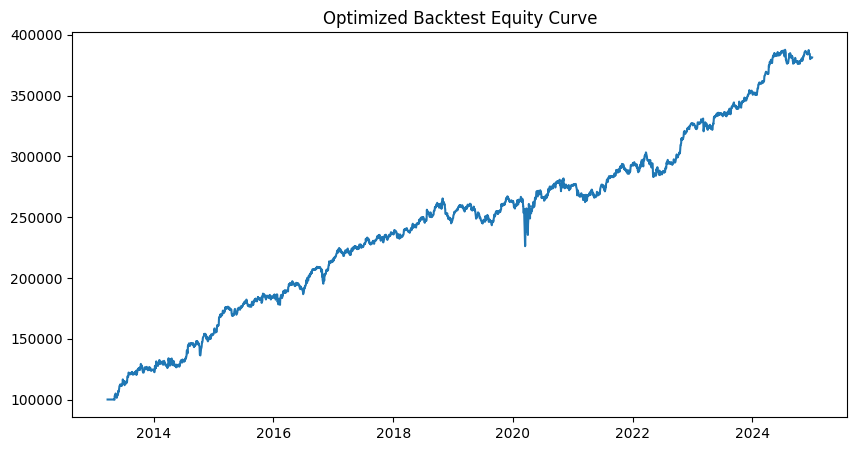

In [19]:
import pandas as pd
import numpy as np
import os
from sb3_contrib import RecurrentPPO
from tqdm.auto import tqdm # Progress bar

def fast_backtest_portfolio(
    monthly_portfolio,
    tech_features,
    rets,
    lookback_resid,
    lookback_corr,
    model_folder=f"{folder_path}models_v1",
    initial_capital=100_000,
    capital_allocation_per_pair=10_000
):
    # -----------------------------------------------------------
    # 1. PRE-CALCULATE TRADING SCHEDULE (The "Mask")
    # -----------------------------------------------------------
    print("Generating Trading Schedule...")

    # Get all unique trading dates from your feature set
    all_dates = pd.to_datetime(tech_features['date'].unique())
    all_dates = np.sort(all_dates)

    # Create a DataFrame to hold allocation masks (1 = Active, 0 = Inactive)
    # Index: Dates, Columns: Pair Keys (e.g. "ORCL-MSFT")
    # This replaces the monthly loop logic with a vectorized lookup
    unique_pairs = monthly_portfolio[['TICKER_1', 'TICKER_2']].drop_duplicates()
    pair_keys = [f"{r.TICKER_1}-{r.TICKER_2}" for _, r in unique_pairs.iterrows()]

    # We will fill this dictionary with boolean Series, then make a DataFrame
    allocation_map = {}

    # Efficiently map months to dates
    # Pre-compute date masks for every Year-Month combo
    date_masks = {}
    for yr in monthly_portfolio['YEAR'].unique():
        for mo in monthly_portfolio['MONTH'].unique():
            # Find start/end dates for this specific month in the data
            mask = (tech_features['date'].dt.year == yr) & (tech_features['date'].dt.month == mo)
            if mask.any():
                dates_in_month = tech_features.loc[mask, 'date'].unique()
                date_masks[(yr, mo)] = dates_in_month

    # Fill the allocation map
    for _, row in unique_pairs.iterrows():
        t1, t2 = row['TICKER_1'], row['TICKER_2']
        key = f"{t1}-{t2}"

        # Find which months this pair is active
        active_months = monthly_portfolio[
            (monthly_portfolio['TICKER_1'] == t1) &
            (monthly_portfolio['TICKER_2'] == t2)
        ][['YEAR', 'MONTH']]

        # Collect all active dates
        active_dates = []
        for _, m_row in active_months.iterrows():
            d_list = date_masks.get((m_row['YEAR'], m_row['MONTH']))
            if d_list is not None:
                active_dates.extend(d_list)

        # Create a boolean series for the full timeline
        # Faster to use set for lookup
        active_dates_set = set(active_dates)
        allocation_map[key] = [d in active_dates_set for d in all_dates]

    # Convert to DataFrame (Rows=Days, Cols=Pairs)
    allocation_df = pd.DataFrame(allocation_map, index=all_dates)

    # Global PnL Aggregator (Day -> Dollar Amount)
    total_daily_pnl = pd.Series(0.0, index=all_dates)

    print(f"Backtesting {len(unique_pairs)} unique pairs...")

    # -----------------------------------------------------------
    # 2. ITERATE UNIQUE PAIRS (Process each pair ONCE)
    # -----------------------------------------------------------
    for i, row in tqdm(unique_pairs.iterrows(), total=len(unique_pairs)):
        t1, t2 = row['TICKER_1'], row['TICKER_2']
        pair_key = f"{t1}-{t2}"

        # A. Find Model
        path = f"{model_folder}/ppo_{t1}_{t2}"
        if not os.path.exists(path):
            # Try swapped name
            path_swapped = f"{model_folder}/ppo_{t2}_{t1}"
            if os.path.exists(path_swapped):
                path = path_swapped
                # Swap tickers for data prep so it matches the trained model
                t1, t2 = t2, t1
            else:
                print(f"Model missing for {t1}-{t2}")
                path = f"{model_folder}/ppo_GE_AVGO"
                # t1, t2 = t2, t1
                # continue

        # B. Prepare Data (ONCE per pair)
        obs, ret1, ret2 = prepare_pair_data_with_advanced_features(
              t1, t2, tech_features, rets, lookback_corr, lookback_resid
          )
        # print(obs[0])
        # Align Dates: Ensure obs matches the global timeline
        # We intersection the obs index with the global all_dates
        common_idx = obs.index.intersection(all_dates)
        if len(common_idx) == 0: continue

        obs = obs.loc[common_idx]
        ret1 = ret1.loc[common_idx]
        ret2 = ret2.loc[common_idx]

        # Get the allocation mask for this specific pair
        # This is 1.0 when we should trade, 0.0 when we should be flat
        # (Aligned to the obs index)
        is_active = allocation_df.loc[common_idx, pair_key].values.astype(float)



        # Optimization: If pair is never active in the overlapping data, skip
        if is_active.sum() == 0:
            print('Not active debug')
        else:
          print(f'data is there')
          print(f'{is_active.sum()}')

        # C. Load Model (ONCE per pair)
        # Use CPU for sequential inference (faster than moving single tensors to GPU)
        model = RecurrentPPO.load(path, device="cpu")
        print( "model loaded successfully")

        # D. Vectorized-ish Inference Loop
        # We still loop for LSTM state, but we do math outside
        obs_values = obs.values.astype(np.float32)
        n_steps = len(obs_values)

        positions = np.zeros(n_steps)

        lstm_states = None
        episode_start = np.ones((1,), dtype=bool)
        current_pos = 1.0

        # The Loop: Calculate positions (Raw -1 to 1)
        for t in range(n_steps):
            # Construct Obs
            step_obs = np.concatenate([obs_values[t], [current_pos]])

            # Predict
            action, lstm_states = model.predict(
                step_obs,
                state=lstm_states,
                episode_start=episode_start,
                deterministic=True
            )
            # print(action)
            current_pos = float(action[0])
            positions[t] = current_pos
            episode_start = np.zeros((1,), dtype=bool)

        # E. Vectorized PnL Calculation
        # 1. Zero out positions on days where this pair is NOT in the portfolio
        # This is the magic step that replaces the monthly loop
        # active_positions = positions * is_active
        active_positions = positions
        print(active_positions)

        # 2. Calculate Returns
        # Position at T captures Return at T+1
        # We shift returns back by 1 to align: P_t * (R_t+1)
        r1_vals = ret1.values
        r2_vals = ret2.values

        # Forward returns
        # Pad the last day with 0 since we don't know T+1
        r1_next = np.roll(r1_vals, -1)
        r2_next = np.roll(r2_vals, -1)
        r1_next[-1] = 0
        r2_next[-1] = 0

        gross_returns = active_positions * (r1_next - r2_next)
        print(gross_returns)

        # Cost: abs(Pos_t - Pos_t-1)
        # We calculate turnover based on the ACTIVE positions (including entry/exit into portfolio)
        pos_change = np.abs(np.diff(active_positions, prepend=0))
        costs =  0

        net_pnl_pct = gross_returns - costs

        # 3. Add Dollar PnL to Global Aggregator
        # Align back to dates using pandas for safety
        pair_daily_dollar_pnl = pd.Series(
            net_pnl_pct * capital_allocation_per_pair,
            index=obs.index
        )

        # Add to total (fill missing dates with 0)
        total_daily_pnl = total_daily_pnl.add(pair_daily_dollar_pnl, fill_value=0)



    # -----------------------------------------------------------
    # 3. CONSTRUCT EQUITY CURVE
    # -----------------------------------------------------------
    # Cumulative Sum of daily profits + Initial Capital
    equity_curve = total_daily_pnl.cumsum() + initial_capital

    return equity_curve

# EXECUTION
dynamic_portfolio_df = select_monthly_dynamic_portfolio(lookback_correlation_pairs, rets, top_n_per_sector=2)
dynamic_portfolio_df = dynamic_portfolio_df[dynamic_portfolio_df['TICKER_1'] != dynamic_portfolio_df['TICKER_2']]
dynamic_portfolio_df = dynamic_portfolio_df[dynamic_portfolio_df['SPEARMAN_RHO'] < 0.98]

equity_curve = fast_backtest_portfolio(
    monthly_portfolio=dynamic_portfolio_df,
    tech_features=tech_features,
    rets=rets,
    lookback_resid=lookback_resid,
    lookback_corr=lookback_correlation_pairs,
    model_folder=f"{folder_path}models_v1",
    initial_capital=100_000,
    capital_allocation_per_pair=10_000
)

plt.figure(figsize=(10, 5))
plt.plot(equity_curve)
plt.title("Optimized Backtest Equity Curve")
plt.show()

In [24]:
pd.DataFrame(equity_curve).to_feather(f"{folder_path}equity_curve.feather")

In [25]:
! pip install quantstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.1 MB/s eta 0:00:00


In [26]:
# !pip install quantstats

import quantstats as qs

# 1. Prepare Returns Series
# Quantstats expects a Daily Returns Series, not prices
returns_series = equity_curve.pct_change().fillna(0)

# 2. Generate Report
# This creates an interactive HTML file with Sharpe, Sortino, Win Rate, Volatility, etc.
qs.reports.html(
    returns_series,
    benchmark="SPY",  # Compare against S&P 500
    title="RL Dynamic Pairs Trading Strategy",
    output=f"{folder_path}backtest_report.html"
)

# 3. Or just plots in notebook
# qs.reports.plots(returns_series, mode='basic')

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [27]:
folder_path

'/content/drive/My Drive/fednlp/ai/'